In [53]:
import numpy as np
import matplotlib.pyplot as plt
from environment import CustomCartPoleEnv

In [54]:
# Softmax function for the policy network
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

class PolicyNetwork:
    def __init__(self, state_size, action_size):
        self.theta = np.random.rand(state_size, action_size)

    def get_action(self, state):
        state = np.expand_dims(state, 0)  # Ensure state is 2D
        logits = state @ self.theta
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
        return np.random.choice(len(policy[0]), p=policy[0])

    def policy(self, state):
        state = np.expand_dims(state, 0)  # Ensure state is 2D
        logits = state @ self.theta
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
        return policy[0]

# Value network class
class ValueNetwork:
    def __init__(self, state_size):
        self.weights = np.random.rand(state_size)

    def predict(self, state):
        return np.dot(state, self.weights)

    def update(self, state, target, alpha):
        value = self.predict(state)
        error = target - value
        self.weights += alpha * error * state

In [55]:
# Helper functions
def generate_episode(env, policy_network):
    states = []
    actions = []
    rewards = []
    state, _ = env.reset()
    while True:
        action = policy_network.get_action(state)
        next_state, reward, terminated, _ = env.step(action)
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        state = next_state
        if terminated:
            break
    return states, actions, rewards

def discount_rewards(rewards, gamma):
    discounted = np.zeros_like(rewards, dtype=np.float32)
    cumulative = 0
    for i in reversed(range(len(rewards))):
        cumulative = cumulative * gamma + rewards[i]
        discounted[i] = cumulative
    return discounted

In [56]:
# REINFORCE algorithm
def reinforce(env, policy_network, episodes, gamma=0.99, alpha=0.01):
    all_rewards = []
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    for episode in range(episodes):
        states, actions, rewards = generate_episode(env, policy_network)
        discounted_rewards = discount_rewards(rewards, gamma)
        for t in range(len(states)):
            Gt = discounted_rewards[t]
            state = states[t]
            action = actions[t]
            policy = policy_network.policy(state)
            dlog = np.zeros_like(policy)
            dlog[action] = 1 - policy[action]
            gradient = alpha * gamma ** t * Gt * np.outer(state, dlog)
            policy_network.theta += gradient

        all_rewards.append(sum(rewards))

    return all_rewards

# Baseline REINFORCE algorithm
def baseline_reinforce(env, policy_network, value_network, episodes, gamma=0.99, alpha=0.01, beta=0.01):
    all_rewards = []

    for episode in range(episodes):
        states, actions, rewards = generate_episode(env, policy_network)
        discounted_rewards = discount_rewards(rewards, gamma)

        for t in range(len(states)):
            state = states[t]
            action = actions[t]
            Gt = discounted_rewards[t]
            baseline = value_network.predict(state)
            td_error = Gt - baseline

            policy = policy_network.policy(state)  # Correct method call
            dlog = np.zeros_like(policy)
            dlog[action] = 1 - policy[action]

            gradient = alpha * gamma ** t * td_error * np.outer(state, dlog)
            policy_network.theta += gradient

            value_network.update(state, Gt, beta)  # Provide alpha (here beta) for the value network update

        all_rewards.append(sum(rewards))

    return all_rewards

In [57]:
# Initialize environment and networks
env = CustomCartPoleEnv()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

policy_network = PolicyNetwork(state_size, action_size)
value_network = ValueNetwork(state_size)

In [58]:
# Run algorithms
episodes = 5000
reinforce_rewards = reinforce(env, policy_network, episodes)

policy_network = PolicyNetwork(state_size, action_size)  # reinitialize policy network
baseline_reinforce_rewards = baseline_reinforce(env, policy_network, value_network, episodes)

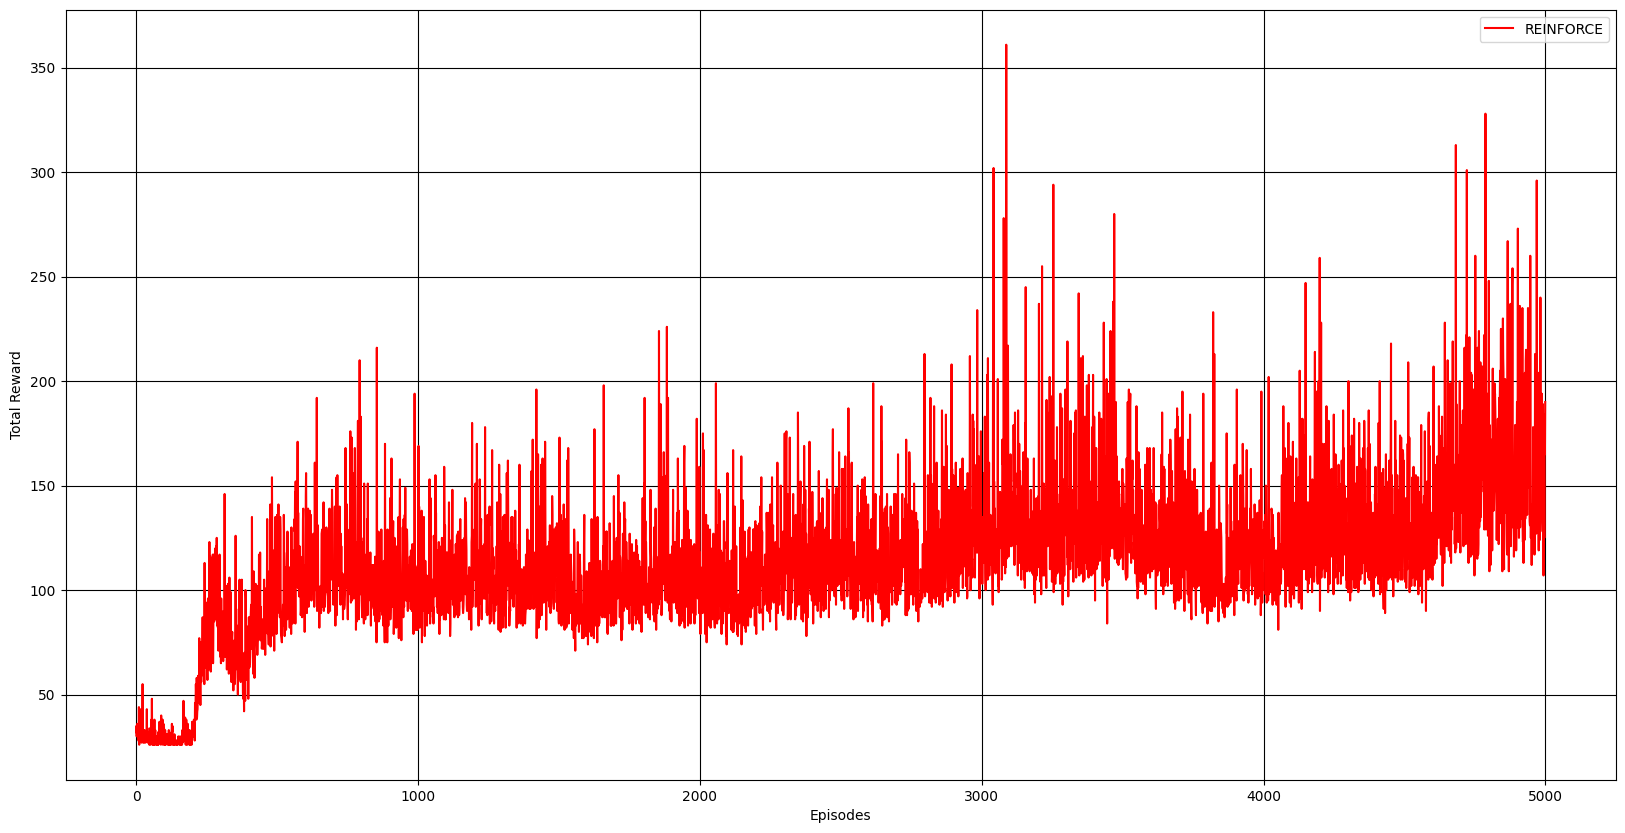

In [59]:
# Plot learning curves for reinforce
plt.figure(figsize=(20, 10))
plt.plot(reinforce_rewards, color='red', label='REINFORCE')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(color = 'black')
plt.show()

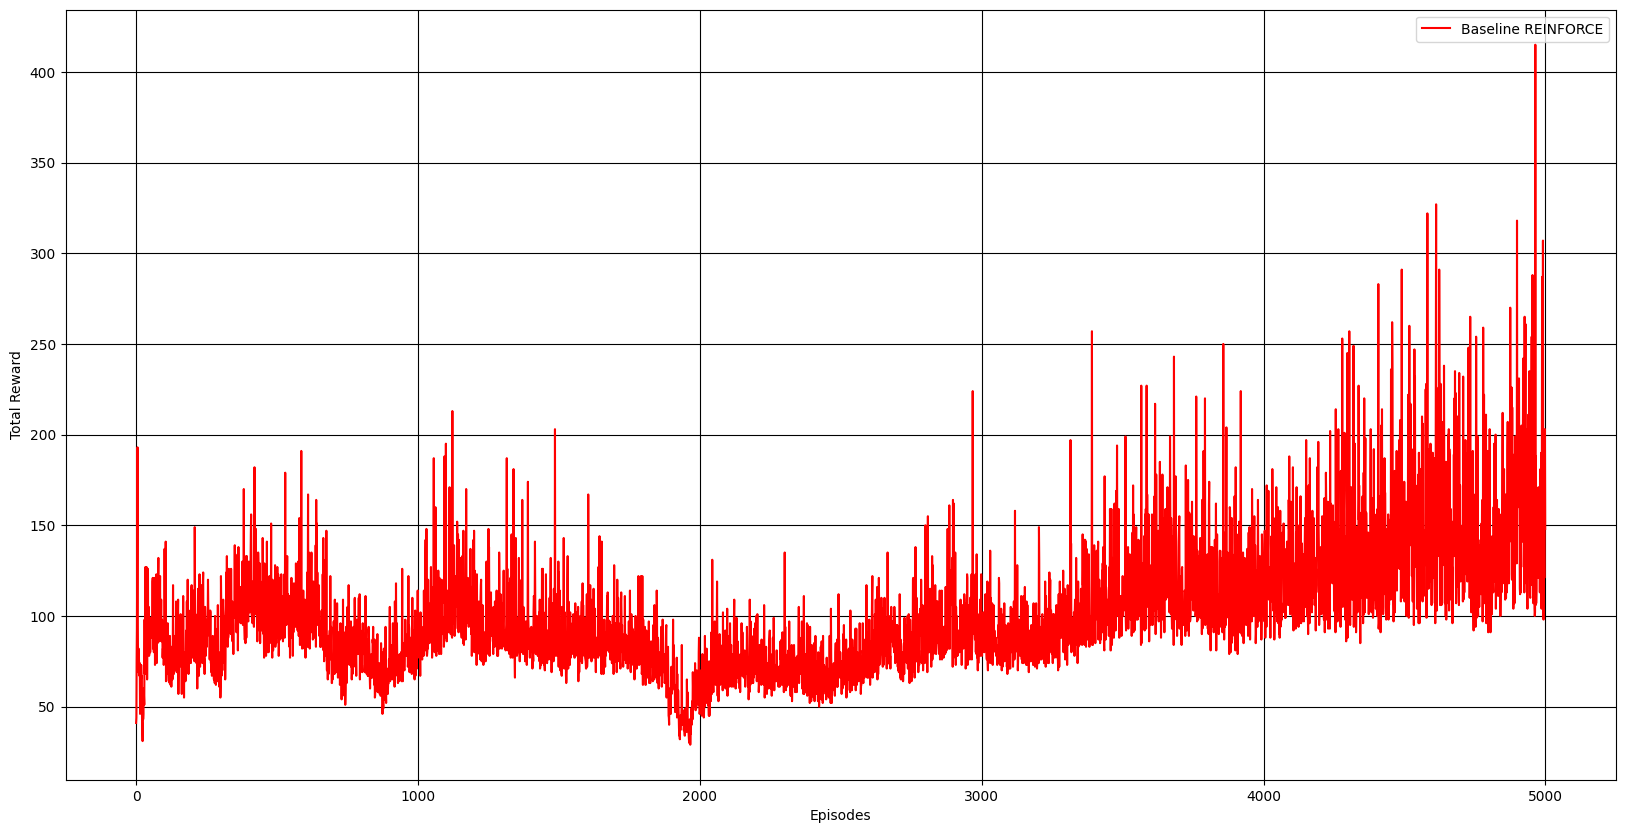

In [60]:
# Plot learning curves for baseline reinforce
plt.figure(figsize=(20, 10))
plt.plot(baseline_reinforce_rewards, color='red', label='Baseline REINFORCE')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(color = 'black')
plt.show()